In [6]:
import os

import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

import pandas as pd

from tqdm import tqdm

import whisper

ver = f'17.0-2024-03-15' # version of the dataset

2.3.0.dev20240311
2.2.0.dev20240311


In [2]:
model = whisper.load_model('base')

100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 64.5MiB/s]


In [4]:
model

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-5): 6 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (key): Linear(in_features=512, out_features=512, bias=False)
          (value): Linear(in_features=512, out_features=512, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (attn_ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (mlp_ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_post): LayerNorm((512,), eps=1e-05,

In [16]:
# helper functions (from https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py)

from IPython.display import Audio
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

torch.random.manual_seed(50)

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


In [8]:
# go to dataset directory
path = f'~/dataset/cv-corpus-{ver}/en'

In [9]:
# read validated audio file table
#tqdm.pandas()
#df = pd.read_csv(f"{path}/validated.tsv", sep='\t').progress_applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = pd.read_csv(f"{path}/validated.tsv", sep='\t')

/var/folders/gn/xf43f2vs2172cb2qv27vz6100000gn/T/ipykernel_28481/904350561.py:4: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{path}/validated.tsv", sep='\t')


In [10]:
df = df.drop(['client_id', 'sentence_id', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment'], axis=1)

In [7]:
df.head()

,path,sentence
0,common_voice_en_27710027.mp3,"Joe Keaton disapproved of films, and Buster al..."
1,common_voice_en_699711.mp3,She'll be all right.
2,common_voice_en_21953345.mp3,six
3,common_voice_en_18132047.mp3,All's well that ends well.
4,common_voice_en_27340672.mp3,It is a busy market town that serves a large s...


In [9]:
df.describe()

,path,sentence
count,1798922,1798922
unique,1798922,1133626
top,common_voice_en_27710027.mp3,yes
freq,1,2495


In [46]:
# load an audio file

# choose a random audio file
i = torch.randint(len(df['path']), (1,)).item()

sentence = df['sentence'].iloc[i]
filename = f"{path}/clips/{df['path'].iloc[i]}"
full_path = os.path.expanduser(filename)

In [50]:
print(filename)
print(full_path)

~/dataset/cv-corpus-17.0-2024-03-15/en/clips/common_voice_en_22934513.mp3
/Users/rayaneeloudrhiri/dataset/cv-corpus-17.0-2024-03-15/en/clips/common_voice_en_22934513.mp3


In [51]:
# load the audio file
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(uri=full_path, normalize=True, format='mp3')

In [52]:
print(sentence)
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE, autoplay=True)

Also, the Thracian settlement of Dardapara existed in Dardania.


In [21]:
# compute the spectrogram of the waveform
n = 512
spectrogram = T.Spectrogram(n_fft=n)

spec = spectrogram(SPEECH_WAVEFORM)

In [39]:
# compute the mel spectrogram of the waveform
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 80

mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

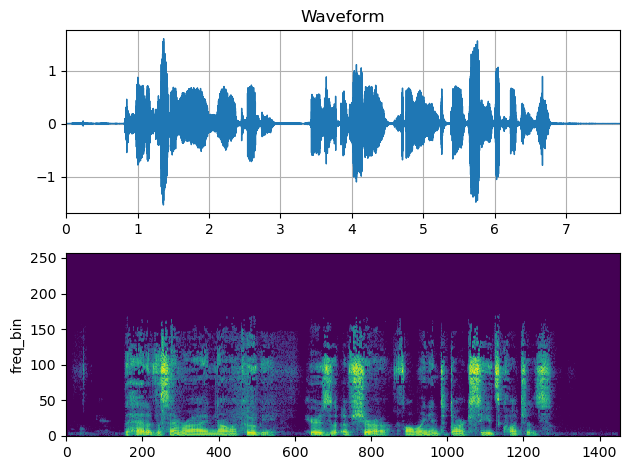

In [13]:
# visualize the waveform and the associated spectrogram
import matplotlib.pyplot as plt

fig, axis = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, ax=axis[0])
plot_spectrogram(spec[0], ax=axis[1])
fig.tight_layout()
plt.show()

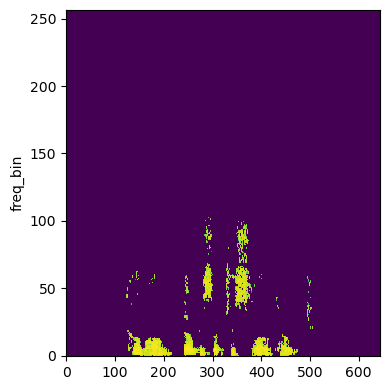

In [29]:
fig, axis = plt.subplots(1, 1, figsize=(4, 4))
plot_spectrogram(spec[0], ax=axis)
fig.tight_layout()
plt.show()

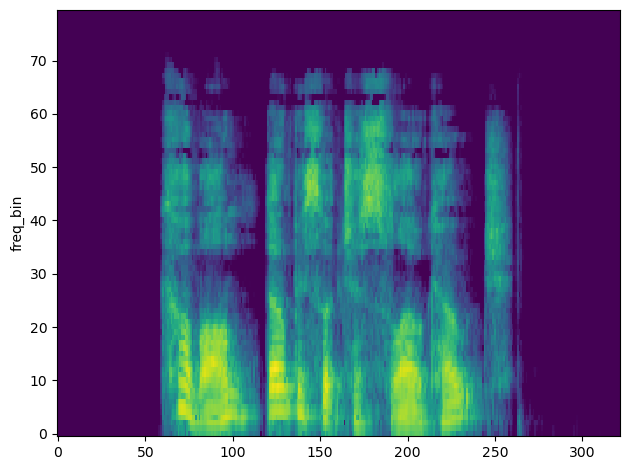

In [45]:
#fig, axis = plt.subplots(1, 1, figsize=(4, 4))
fig, axis = plt.subplots(1, 1)
plot_spectrogram(melspec[0], ax=axis)

fig.tight_layout()
plt.show()

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 8.3503e-15, 5.1755e-12,  ..., 2.8670e-13,
          5.2413e-09, 4.8665e-09],
         [0.0000e+00, 4.2465e-15, 2.6320e-12,  ..., 1.4580e-13,
          2.6654e-09, 2.4748e-09],
         ...,
         [0.0000e+00, 1.2201e-23, 1.0818e-21,  ..., 2.2880e-22,
          4.0939e-20, 6.6721e-18],
         [0.0000e+00, 8.6167e-24, 8.6792e-22,  ..., 2.5828e-22,
          2.6723e-20, 6.4469e-18],
         [0.0000e+00, 4.9870e-24, 5.0854e-22,  ..., 2.4086e-22,
          6.6690e-20, 6.3278e-18]]])

In [ ]:
class SpeechEncoder(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self):
        return
